In [1]:
#Create references to important directories we will use over and over
import os, sys
current_dir = os.getcwd()
LESSON_HOME_DIR = current_dir
DATA_HOME_DIR = current_dir+'/data/redux'
#Allow relative imports to directories above lesson1/
sys.path.insert(1, os.path.join(sys.path[0], '..'))

#import modules
from utils import *
from vgg16 import Vgg16

import time

from keras.preprocessing import image

#Instantiate plotting tool
#In Jupyter notebooks, you will need to run this command before doing any plotting
%matplotlib inline

Using gpu device 0: Tesla K80 (CNMeM is disabled, cuDNN 5103)
/home/ubuntu/anaconda2/lib/python2.7/site-packages/theano/sandbox/cuda/__init__.py:600: UserWarning: Your cuDNN version is more recent than the one Theano officially supports. If you see any problems, try updating Theano or downgrading cuDNN to version 5.
  warnings.warn(warn)
Using Theano backend.


In [2]:
# iniialize the model
vgg = Vgg16()

In [86]:
batch_size = 64
epochs = 20
path = DATA_HOME_DIR + '/'
valid_path = path + 'valid/'
train_path = path + 'train/'
test_path = path + 'test/'

In [87]:
train_batches = vgg.get_batches(train_path, batch_size=batch_size)
valid_batches = vgg.get_batches(valid_path, batch_size=batch_size)
vgg.finetune(train_batches)

Found 23000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.


In [ ]:
for e in range(epochs):
    vgg.fit(train_batches, valid_batches)
    vgg.model.save_weights(path + 'results/model' + str(time.time()))

Epoch 1/1
 1984/23000 [=>............................] - ETA: 529s - loss: 0.3619 - acc: 0.8977

In [55]:
vgg.model.load_weights(DATA_HOME_DIR + '/results/ft1.h5')

In [79]:
valid_batches, preds = vgg.test(valid_path, batch_size=batch_size)

Found 2000 images belonging to 2 classes.


In [57]:
valid_batches.class_indices

{'cats': 0, 'dogs': 1}

In [58]:
def onehot(batches):
    num_classes = len(batches.class_indices)
    return np.equal(batches.classes, np.matrix(np.arange(num_classes)).T).T.astype(int)

In [59]:
def logloss(batches, preds):
    preds = np.clip(preds, 0.0001, 0.9999)
    v1 = np.multiply(valid_batches.classes, np.log(preds[:, 1]))
    v2 = np.multiply(1-valid_batches.classes, np.log(1-preds[:, 1]))
    return np.sum(np.add(v1, v2)) / -valid_batches.N

In [60]:
logloss(valid_batches, preds)

0.13542897057669326

In [61]:
labels = np.round(1-preds[:,0])
text_labels = ["dog" if dog else "cat" for dog in labels]
correct_labels = labels == valid_batches.classes
correct_cats = correct_labels & (valid_batches.classes==0)
correct_dogs = correct_labels & (valid_batches.classes==1)
wrong_cats = ~correct_labels & (valid_batches.classes==0)
wrong_dogs = ~correct_labels & (valid_batches.classes==1)

In [62]:
def plot_images(batches, labels, preds, idxs, num, path):
    if len(idxs) == 0:
        return
    idxs = np.random.choice(idxs, num)
    filenames = [path + batches.filenames[i] for i in idxs]
    labels = [str(labels[i]) + " " + str(preds[i]) for i in idxs]
    plots([image.load_img(f) for f in filenames], titles=labels)

[[1026   16]
 [  16  942]]


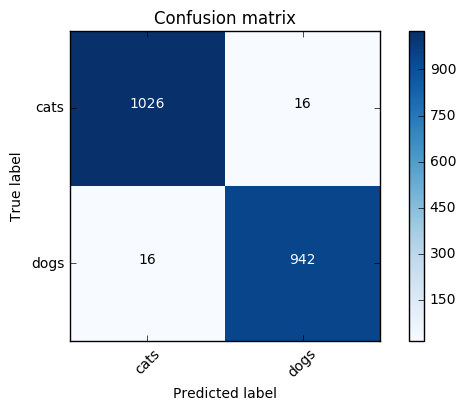

In [63]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(valid_batches.classes, labels)
plot_confusion_matrix(cm, valid_batches.class_indices)

# Wrong dogs

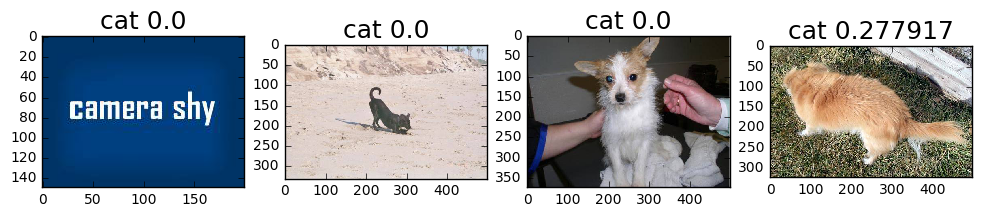

In [64]:
plot_images(valid_batches, text_labels, 1-preds[:, 0], np.where(wrong_dogs)[0], 4, valid_path)

# Wrong cats

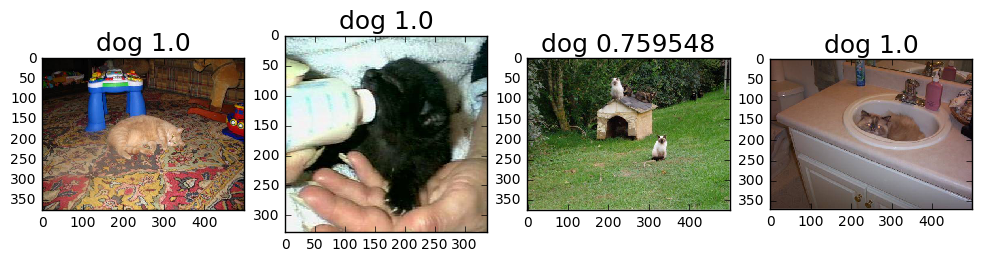

In [65]:
plot_images(valid_batches, text_labels, 1-preds[:, 0], np.where(wrong_cats)[0], 4, valid_path)

# Correct dogs

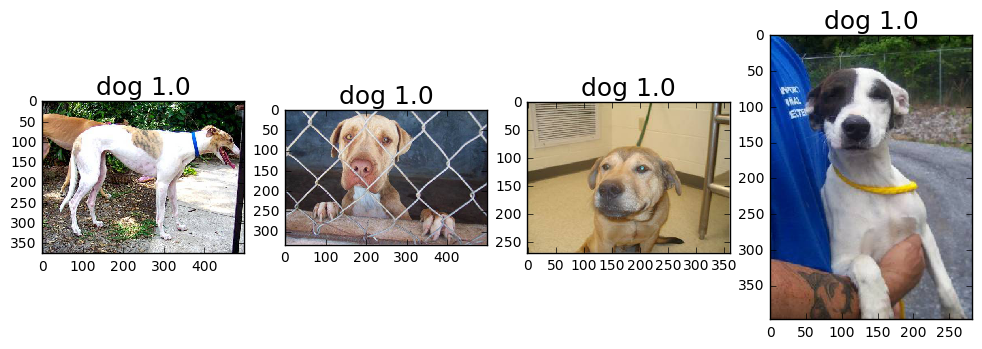

In [66]:
plot_images(valid_batches, text_labels, 1-preds[:, 0], np.where(correct_dogs)[0], 4, valid_path)

# Correct cats

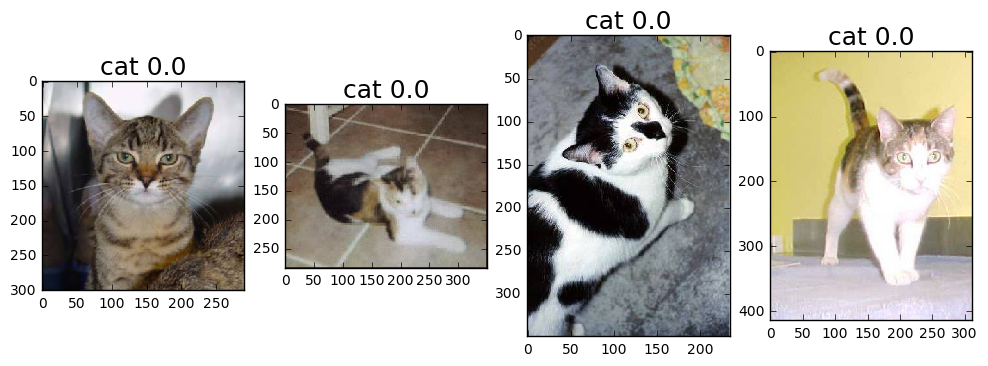

In [67]:
plot_images(valid_batches, text_labels, 1-preds[:, 0], np.where(correct_cats)[0], 4, valid_path)

# Run for test data

In [68]:
test_batches, test_preds = vgg.test(test_path, batch_size=batch_size)
test_labels = np.round(1-test_preds[:, 0])
text_labels = ["dog" if dog else "cat" for dog in test_labels]
dogs = test_labels == 1
cats = test_labels == 0

Found 12500 images belonging to 1 classes.


# We think they're dogs

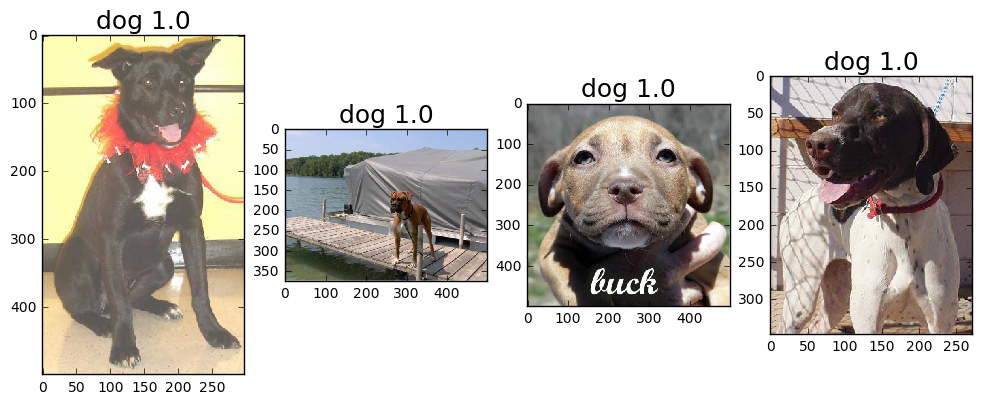

In [69]:
plot_images(test_batches, text_labels, 1-test_preds[:, 0], np.where(dogs)[0], 4, test_path)

# We thing they're cats

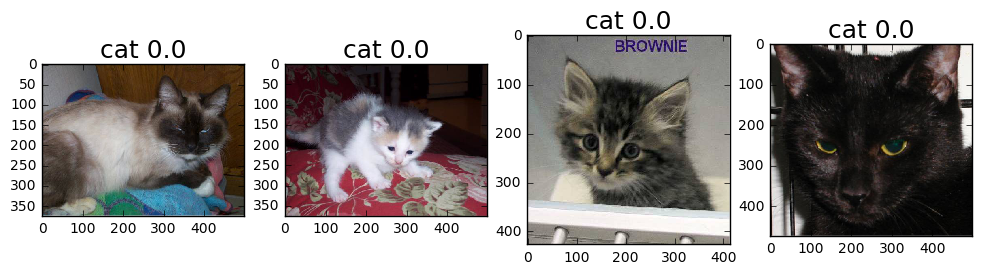

In [70]:
plot_images(test_batches, text_labels, 1-test_preds[:, 0], np.where(cats)[0], 4, test_path)

In [82]:
import re
r = re.compile('\d+')
filename=path + 'results/submission.csv'
with open(filename, 'w') as f:
    f.write("id,label\n")
    for i, filename in enumerate(test_batches.filenames):
       f.write("%s,%f\n" % (r.search(filename).group(), test_preds[i, 1]))